In [6]:
using Agents
using CairoMakie
using Makie

using GeometryBasics
using Random
using LinearAlgebra
using Plots
using KernelDensity
using QuadGK
using Interpolations
using StatsBase
using Statistics
using DataFrames
using Loess
using DataStructures
using Measures
using InteractiveDynamics
using StaticArrays


In [3]:
Pkg.add("StaticArrays")
Pkg.add("CairoMakie")
Pkg.add("Makie")
Pkg.add("Agents")
Pkg.add("GeometryBasics")
Pkg.add("Random")
Pkg.add("LinearAlgebra")
Pkg.add("Plots")
Pkg.add("KernelDensity")
Pkg.add("QuadGK")
Pkg.add("Interpolations")
Pkg.add("StatsBase")
Pkg.add("Statistics")
Pkg.add("DataFrames")
Pkg.add("Loess")
Pkg.add("DataStructures")
Pkg.add("Measures")
Pkg.add("InteractiveDynamics")

    Updating registry at `C:\Users\victo\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\victo\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\victo\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\victo\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\victo\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\victo\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\victo\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\victo\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\victo\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
    Updating `C:\Users\victo\.julia\environments\v1.7\Project.toml`
  [5c1252a2] + GeometryBasics v0.4.2
  No Changes to `C:\Users\victo\.julia\environments\v1.7\Manifest.toml`
   Resolving 

In [1]:
import Pkg;

In [8]:
println("Agents.jl version: ", Pkg.installed()["Agents"])

┌ Warning: Pkg.installed() is deprecated
└ @ Pkg C:\Users\victo\AppData\Local\Programs\Julia-1.10.4\share\julia\stdlib\v1.10\Pkg\src\Pkg.jl:744


Agents.jl version: 6.2.4


In [9]:
plot_num = 1
plot_num_update() = global plot_num += 1
plot_num_reset() = global plot_num = 1
function plot_save(p) 
    savefig(p,"Figure$(plot_num).png")
    savefig(p,"Figure$(plot_num).pdf")
    plot_num_update()
end

plot_save (generic function with 1 method)

In [10]:
function moving_average(values, window_size)
    len = length(values)
    smoothed_values = zeros(len)
    for i in 1:len
        start_index = max(1, i - window_size + 1)
        end_index = i
        smoothed_values[i] = mean(values[start_index:end_index])
    end
    return smoothed_values
end

function exponential_moving_average(values, α)
    len = length(values)
    EMA = zeros(len)
    EMA[1] = values[1]
    for i in 2:len
        EMA[i] = α * values[i] + (1 - α) * EMA[i-1]
    end
    return EMA
end

exponential_moving_average (generic function with 1 method)

In [11]:

@agent struct Bird{T}(ContinuousAgent{2,T}) # (ContinuousAgent{2, Float64})
    speed::T # how far it travels
    cohere_factor::T # group cohesion importance
    separation::T # minimum distance from neighbors
    separate_factor::T # importance of separation maintenance
    match_factor::T # importance of maintaining similar trajectories
    visual_distance::T # how far agent sees/scan neighbors (radius)
    ensemble::T # number of birds in the flock the bird belongs to
    ensemble_history::CircularBuffer{T}
end

In [12]:
SEED = 12;

In [13]:
model_iteration = 0

function initialize_model(; n_birds = 40,
    speed = 2.0,
    cohere_factor = 0.4,
    separation = 4.0, separate_factor = 0.25,
    match_factor = 0.02,
    visual_distance = 5.0,
    ensemble = 1,
    history_length = 8,
    extent = (50, 50), 
    seed = 1234,
    agent_step! = dummystep,
    model_step! = dummystep)
    
    global model_iteration = 0
    
    space2d = ContinuousSpace(extent; spacing = visual_distance / 1.5)
    rng = Random.MersenneTwister(seed)

    model = ABM(Bird{Float64}, space2d; rng=rng, scheduler = Schedulers.Randomly(), 
                        agent_step! = agent_step!, model_step! = model_step!)
    
    for _ in 1:n_birds
        vel = SVector{2}(rand(rng, 2) * 2 .- 1)
        pos = SVector{2}(rand(rng, 2) .* extent)
        
        add_agent!(
            pos,
            model,
            vel,
            speed,
            cohere_factor,
            separation,
            separate_factor,
            match_factor,
            visual_distance,
            ensemble,
            CircularBuffer{Float64}(history_length)
        )
    end
    return model
end


initialize_model (generic function with 1 method)

In [14]:
function agent_step!(bird, model)
    # Obtain the ids of neighbors within the bird's visual distance
    neighbor_ids = nearby_ids(bird, model, bird.visual_distance)

    match = separate = cohere = (0.0, 0.0)
    
    angle_threshold = 120 * (pi / 180)
    bird_speed = norm(bird.vel)
    ensemble_count = 0
        
    for id in neighbor_ids
        neighbor = model[id].pos
        heading = neighbor .- bird.pos

        # `cohere` computes the average position of neighboring birds
        cohere = cohere .+ heading

        if euclidean_distance(bird.pos, neighbor, model) < bird.separation
            # `separate` repels the bird away from neighboring birds
            separate = separate .- heading
        end
        # `match` computes the average trajectory of neighboring birds
        match = match .+ model[id].vel
        
        
        neighbor_speed = norm(model[id].speed)        
        angle_between = acos(dot(bird.vel, model[id].vel) / (bird_speed * neighbor_speed + 1e-9))  # Adding a small epsilon to avoid division by zero
        speed_difference = abs(bird_speed - neighbor_speed) / (bird_speed + 1e-9)  # Adding a small epsilon to avoid division by zero
        
        if angle_between < angle_threshold #|| (speed_difference < 2 || speed_difference > 0.5)
            ensemble_count += 1
        end        
                
    end
    
    N = max(length(collect(neighbor_ids)), 1)
    
    # Update the ensemble history
    push!(bird.ensemble_history, length(collect(neighbor_ids)))
    
    bird.ensemble = 1 / (1 + median(bird.ensemble_history))
    
    # Normalise results based on model input and neighbor count
    cohere = cohere ./ N .* bird.cohere_factor
    separate = separate ./ N .* bird.separate_factor
    
    match = match ./ N .* bird.match_factor
    # Compute velocity based on rules defined above
    bird.vel = (bird.vel .+ cohere .+ separate .+ match) ./ 2
    bird.vel = bird.vel ./ norm(bird.vel)
    # Move bird according to new velocity and speed
    
    #bird.ensemble = ensemble_countfunction agent_step!(bird, model)
    #bird.ensemble = ensemble_count
    
    move_agent!(bird, model, bird.speed)
end


agent_step! (generic function with 1 method)

In [15]:
function model_step!(model)
    global model_iteration += 1    
end

model_step! (generic function with 1 method)

In [16]:
# model = initialize_model()
model = initialize_model(
    agent_step! = agent_step!,
    model_step! = model_step!
)

StandardABM with 40 agents of type Bird
 agents container: Dict
 space: periodic continuous space with [50.0, 50.0] extent and spacing=3.3333333333333335
 scheduler: Agents.Schedulers.Randomly

## Energies



In [35]:
function Model_Ensemble_Energy(model)
    energy = 0
    
    for bird in allagents(model)        
        energy += bird.ensemble
    end
    
    return energy
end

Model_Ensemble_Energy (generic function with 1 method)

In [36]:
function Model_Energy_DistributionFN(model) 
    energies = []

    for bird in allagents(model)
        push!(energies, bird.ensemble)
    end
    
    energies_float = float.(energies)

    hist = fit(Histogram, energies_float, closed=:left)

    total_count = sum(hist.weights)
    pdf = hist.weights ./ total_count

    # This will include the bin centers (or edges) and the corresponding probabilities
    energy_bins = midpoints(hist.edges[1])
    energy_distribution = [(e, p) for (e, p) in zip(energy_bins, pdf)]

    return energy_distribution
end

Model_Energy_DistributionFN (generic function with 1 method)

In [37]:
function Model_Entropy(e_p_array)
    S = 0.0

    for (e, p) in e_p_array
        # Only add to the sum if p is non-zero to avoid log(0)
        if p > 0
            S -= p * log(p)
        end
    end

    return S  
end

Model_Entropy (generic function with 1 method)

In [38]:
# T = -((\int_{E_min}^{E_max} (dp(E)/dE) * ln(p(E)) dE)^-1 
# summation in discrete situation 
# p(E) the probability distribution of the energies E, and E_min and E_max 
function Model_Temperature(e_p_array)
    sum_result = 0.0

    # Iterate through the e_p_array to approximate the integral using finite differences
    for i in 2:length(e_p_array)
        E_prev, p_prev = e_p_array[i - 1]
        E, p = e_p_array[i]

        # Compute the finite difference approximation of dp/dE
        delta_E = E - E_prev
        dp_dE = (p - p_prev) / delta_E

        if( dp_dE >= 10^8 || dp_dE <= 10^(-8) || dp_dE == 0 ) continue end

        # Only consider non-zero probabilities to avoid logarithm of zero
        if p > 0
            sum_result += dp_dE * log(p)
        end
    end
    
    # Handle the case where the sum_result is zero to avoid division by zero
    if sum_result == 0
        return 0  # Return infinity if the sum is zero, indicating a very high temperature
    else
        T = -1 / sum_result
        return abs(T)
    end
end


Model_Temperature (generic function with 1 method)

In [39]:
function Model_Heat(S_current, S_prev, T_current)
    dS = S_current - S_prev
    dQ = abs(T_current) * dS#abs(dS)
    return dQ
end

Model_Heat (generic function with 1 method)

In [40]:
flag = false
function Model_Internal_Energy( model )
    global flag
    e_p_array = Model_Energy_DistributionFN(model)
    
#     flag ? flag=true : println(e_p_array)
    
    tmp_U = 0 
    
    for tup in e_p_array
        tmp_U += tup[1] * tup[2]
    end
    
    return tmp_U
end

Model_Internal_Energy (generic function with 1 method)

In [41]:
global S_prev;

function Model_Thermo_State(model)
    
    e_p_array = Model_Energy_DistributionFN(model)
    S = Model_Entropy(e_p_array)
    T = Model_Temperature(e_p_array)
    #T = log.(T)
    
    dQ = 0;
    
    if(model_iteration > 0)
        dQ = Model_Heat(S, S_prev, T)
    end
    
    global S_prev = S;
    
    return Dict("S"=>S,"T"=>T,"dQ"=>dQ, "e_p_array"=>e_p_array)
end

Model_Thermo_State (generic function with 1 method)

In [43]:
function Flock_Model_State(model)
    energy = Model_Ensemble_Energy(model)
    fig_tmp = Plot_Birds_Iter(model, energy, model_iteration)
    return fig_tmp
end

Flock_Model_State (generic function with 1 method)

In [44]:
function Model_Volume( model )
#     println("baz")
#     birds = allagents(model)
    birds = collect(allagents(model))
    total_distance = 0.0
    count = 0

    # Calculate pairwise distances
    for i in 1:length(birds)-1
        for j in i+1:length(birds)
            dist = euclidean_distance(birds[i].pos, birds[j].pos, model)
            total_distance += dist
            count += 1
        end
    end

    # Compute the average distance
    if count > 0
        average_distance = total_distance / count
    else
        average_distance = 0.0
    end
    
    if average_distance > 0 
        return 1 / average_distance
    else
        return 0
    end
    
end

Model_Volume (generic function with 1 method)

In [46]:
function Step_Num(model)
    return model_iteration 
end

Step_Num (generic function with 1 method)

In [48]:
bird_polygon = Makie.Polygon(Point2f[(-1, -1), (2, 0), (-1, 1)])

function bird_marker(b::Bird)
    φ = atan(b.vel[2], b.vel[1]) #+ π/2 + π
    rotate_polygon(bird_polygon, φ)
end

function Plot_Birds_Iter(model, heat_tmp, iteration_tmp)    
    title_str = "E=$heat_tmp at iter=$iteration_tmp"
    figure, = Agents.abmplot(model; agent_marker = bird_marker, aspect = 1, 
                                axis = (; title = title_str, titlesize=20) )
    return figure    
end

Plot_Birds_Iter (generic function with 1 method)

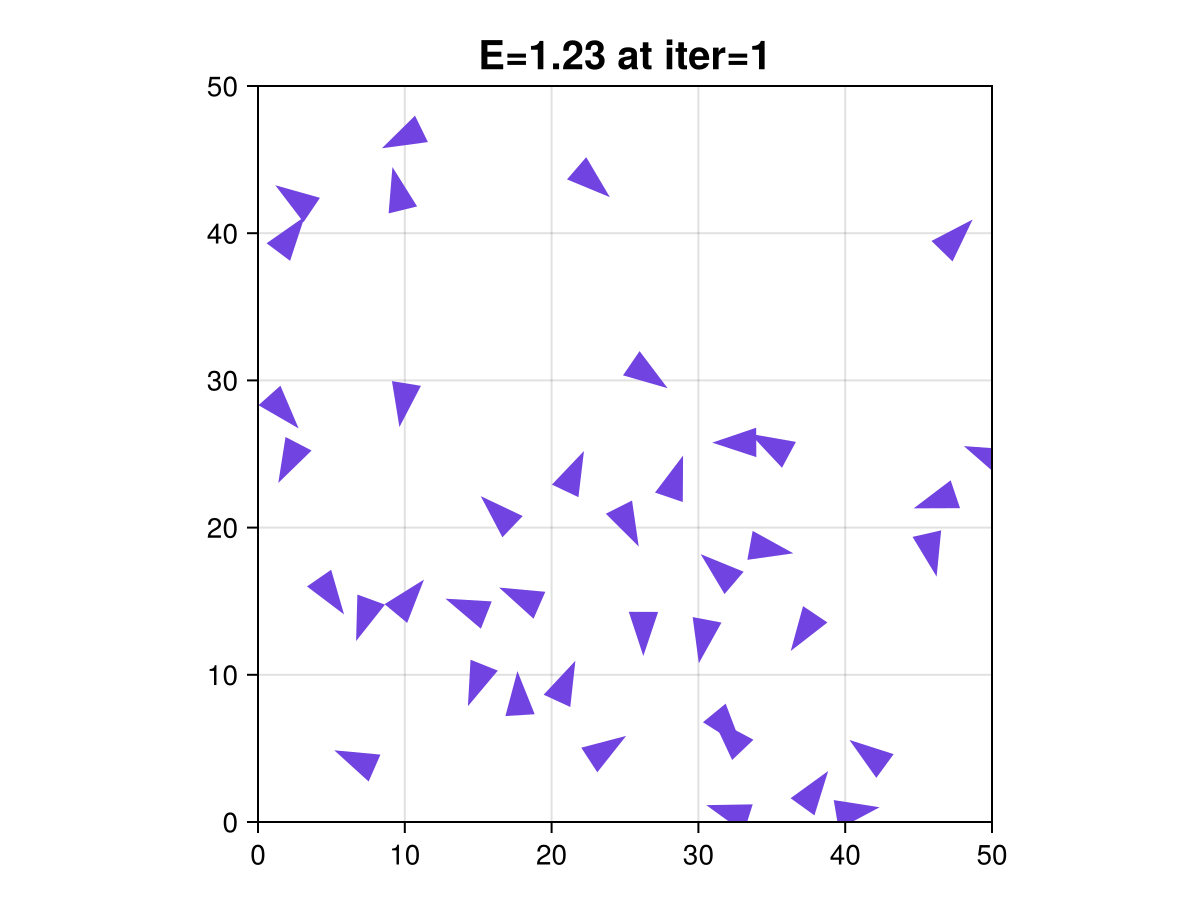

In [49]:
Plot_Birds_Iter(initialize_model(), 1.23, 1)

In [51]:
model = initialize_model(agent_step! = agent_step!, model_step! = model_step!)

adata = [ :separation, :speed, :ensemble ]
mdata = [ Step_Num, Model_Ensemble_Energy, Model_Thermo_State, 
    Flock_Model_State, Model_Volume, Model_Internal_Energy ]

step_num = 150
agent_df, model_df = run!(model, step_num; adata , mdata);

LEARNING  GMM 

In [52]:
#Install Required Packages
using Pkg
Pkg.add(["Agents", "Distributions", "StatsBase", "Plots", "GaussianMixtures", "Random", "LinearAlgebra"])


   Resolving package versions...
  No Changes to `C:\Users\victo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\victo\.julia\environments\v1.10\Manifest.toml`
Precompiling project...
  ? StochasticDiffEq
  ? DifferentialEquations


Extract Features for GMM Training - We will extract thermodynamic properties from the model and use them as features for GMM clustering.

In [53]:
using GaussianMixtures, StatsBase

function extract_features_from_model(model_df)
    S_vals = model_df[:, :Model_Thermo_State] .|> x -> x["S"]
    T_vals = model_df[:, :Model_Thermo_State] .|> x -> x["T"]
    dQ_vals = model_df[:, :Model_Thermo_State] .|> x -> x["dQ"]
    E_vals = model_df[:, :Model_Ensemble_Energy]
    V_vals = model_df[:, :Model_Volume]

    # Convert to feature matrix
    data = hcat(E_vals, S_vals, T_vals, dQ_vals, V_vals)
    return data
end


extract_features_from_model (generic function with 1 method)

Train Gaussian Mixture Model (GMM) We will train a Gaussian Mixture Model (GMM) to classify birds into different flocking states based on thermodynamic properties.

In [54]:
function train_gmm(data, num_clusters)
    println("Training GMM with $num_clusters clusters...")
    gmm = GMM(num_clusters, data; method=:kmeans)  # Fit GMM using K-means initialization
    return gmm
end


train_gmm (generic function with 1 method)

Apply Thermodynamic Constraints -
We enforce entropy minimization and energy reduction in the GMM optimization.

In [55]:
#Thermodynamic Constraint Enforcement
function enforce_thermodynamic_constraints!(gmm, data)
    entropy_values = data[:, 2]  # Extract entropy column
    if any(diff(entropy_values) .> 0)  # Check if entropy increases
        println("Warning: Some clusters violate entropy reduction!")
    end

    # Ensure energy minimization
    if mean(data[:, 1]) > 0.5
        println("Adjusting clusters: Energy minimization violated.")
        gmm = GMM(length(gmm.p), data * 0.95)  # Scale down clusters slightly
    end
    return gmm
end


enforce_thermodynamic_constraints! (generic function with 1 method)

Run Simulation and Train GMM
We now run the flocking simulation and apply GMM clustering.

Full Execution

In [ ]:
# Initialize and run the model
model = initialize_model(agent_step! = agent_step!, model_step! = model_step!)

adata = [ :separation, :speed, :ensemble ]
mdata = [ Step_Num, Model_Ensemble_Energy, Model_Thermo_State, 
    Flock_Model_State, Model_Volume, Model_Internal_Energy ]

step_num = 150
agent_df, model_df = run!(model, step_num; adata , mdata)

# Extract features for GMM training
data = extract_features_from_model(model_df)

# Train GMM
num_clusters = 3  # Define number of clusters
gmm = train_gmm(data, num_clusters)

# Enforce thermodynamic constraints
gmm = enforce_thermodynamic_constraints!(gmm, data)

println("GMM training completed.")


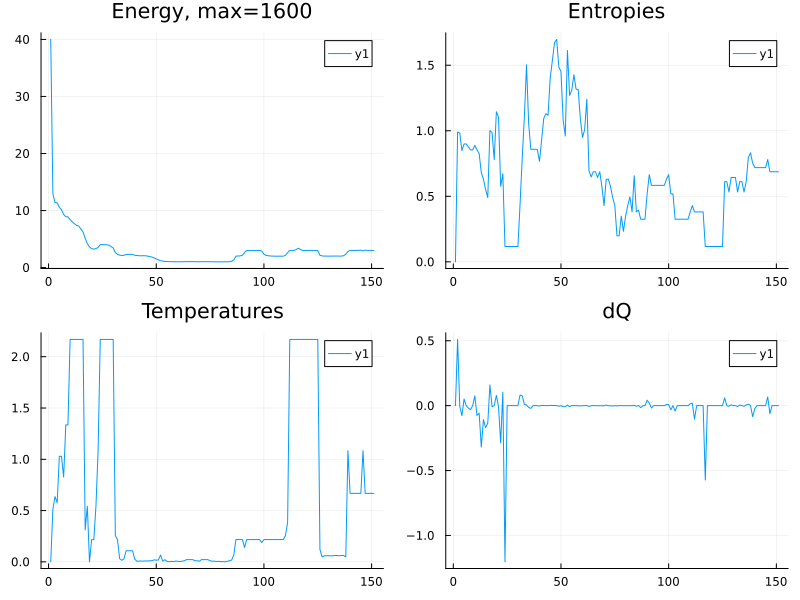

In [62]:
p1 = Plots.plot( model_df[ :, :Model_Ensemble_Energy], title="Energy, max=$(40^2)" )

S_vals = model_df[ :, :Model_Thermo_State] .|> x -> x["S"]
p2 = Plots.plot( S_vals, title="Entropies" )

T_vals = model_df[ :, :Model_Thermo_State] .|> x -> x["T"]
p3 = Plots.plot( T_vals, title="Temperatures" )

dQ_vals = model_df[ :, :Model_Thermo_State] .|> x -> x["dQ"]
p4 = Plots.plot( dQ_vals, title="dQ" )

p = Plots.plot(p1,p2,p3,p4, size=(800,600))
#savefig(p,"EnergyEntropyTemperatureHeat.png")
display(p)

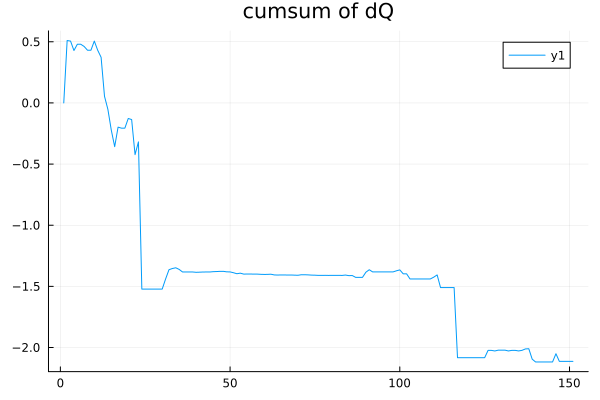

In [63]:
Plots.plot(cumsum(dQ_vals), title="cumsum of dQ")

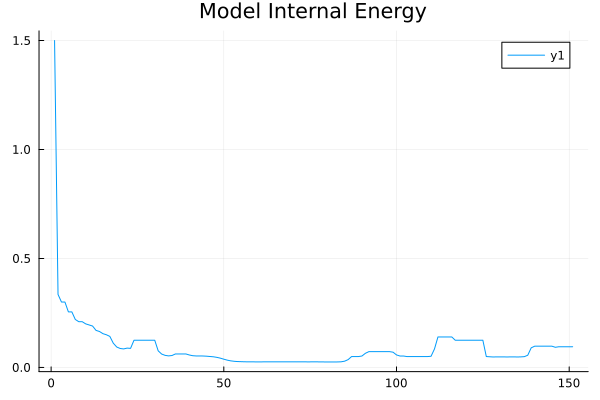

In [64]:
p = Plots.plot( model_df[ :, :Model_Internal_Energy], title="Model Internal Energy" )


In [65]:
names(model_df)

7-element Vector{String}:
 "time"
 "Step_Num"
 "Model_Ensemble_Energy"
 "Model_Thermo_State"
 "Flock_Model_State"
 "Model_Volume"
 "Model_Internal_Energy"

In [66]:
#model_df[ :, :Model_Volume] .|> x -> x["V"]
#names(model_df)

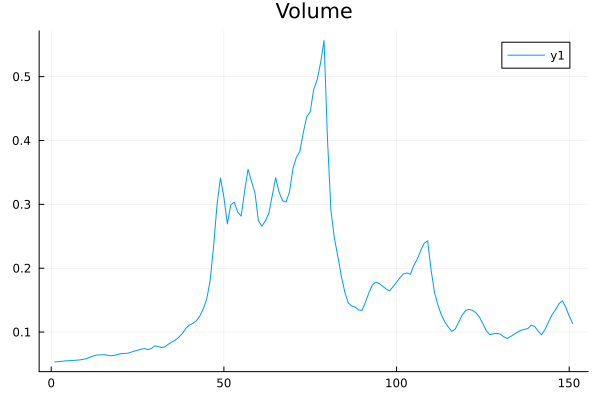

In [67]:
p = Plots.plot( model_df[ :, :Model_Volume], title="Volume" )


In [68]:
e_p_array = model_df[ :, :Model_Thermo_State] .|> x -> x["e_p_array"]
e_p_array;

In [69]:
sum( map( x-> x[2], e_p_array[3] ) )

1.0

In [70]:
ep_tmp = model_df[:, :Model_Thermo_State] .|> x -> x["e_p_array"];

In [71]:
e_p_sums = zeros(1, length(model_df[:, :Model_Thermo_State] .|> x -> x["e_p_array"]))
e_p_sums = map( x -> [(0,0)], e_p_sums );

In [72]:
function Merge_E_P_Array(ep_tmp, e_p_sums)
    # Initialize a new accumulator for the merged data
    new_e_p_array = copy(e_p_sums)
    
    for i in 1:length(ep_tmp)
        # Find matching energy levels and sum their probabilities
        for (E, p) in ep_tmp[i]
            found = false
            for j in 1:length(new_e_p_array[i])
                if new_e_p_array[i][j][1] == E
                    new_e_p_array[i][j] = (E, new_e_p_array[i][j][2] + p)
                    found = true
                    break
                end
            end
            # If the energy level is not found, add the new tuple
            if !found
                push!(new_e_p_array[i], (E, p))
            end
        end
    end
    
    return new_e_p_array
end

function Normalize_E_P_Array(e_p_array)
    normalized_e_p_array = copy(e_p_array)
    for i in 1:length(e_p_array)
        total_probability = sum(map(x -> x[2], e_p_array[i]))
        if total_probability != 0
            normalized_e_p_array[i] = map(x -> (x[1], x[2] / total_probability), e_p_array[i])
        end
    end
    return normalized_e_p_array
end

Normalize_E_P_Array (generic function with 1 method)

In [ ]:
num_simulations = 300
step_num = 150
adata = [ :separation, :speed, :ensemble ]
mdata = [ Step_Num, Model_Ensemble_Energy, Model_Thermo_State, 
    Flock_Model_State, Model_Volume, Model_Internal_Energy ]

# Run the first simulation to initialize accumulators
model = initialize_model(agent_step! = agent_step!, model_step! = model_step!)
agent_df, model_df = run!(model, step_num; adata, mdata)

energy_sums = copy(model_df[:, :Model_Ensemble_Energy])
S_sums = model_df[:, :Model_Thermo_State] .|> x -> x["S"]
T_sums = model_df[:, :Model_Thermo_State] .|> x -> x["T"]
dQ_sums = model_df[:, :Model_Thermo_State] .|> x -> x["dQ"]

V_sums = model_df[:, :Model_Volume]
U_sums = model_df[:, :Model_Internal_Energy]

e_p_sums = model_df[:, :Model_Thermo_State] .|> x -> x["e_p_array"]


for i in 2:num_simulations
#     global SEED = num_simulations;
    print("i=$i, ")
    model = initialize_model(seed = i, agent_step! = agent_step!, model_step! = model_step!)
    agent_df, model_df = run!(model, step_num; adata, mdata)

    # Check and accumulate values
    energy_sums .+= model_df[:, :Model_Ensemble_Energy]
    S_sums .+= model_df[:, :Model_Thermo_State] .|> x -> x["S"]
    T_sums .+= model_df[:, :Model_Thermo_State] .|> x -> x["T"]
    dQ_sums .+= model_df[:, :Model_Thermo_State] .|> x -> x["dQ"]
    V_sums .+= model_df[:, :Model_Volume]
    U_sums .+= model_df[:, :Model_Internal_Energy]
    
    ep_tmp = model_df[:, :Model_Thermo_State] .|> x -> x["e_p_array"]
    e_p_sums = Merge_E_P_Array(ep_tmp, e_p_sums)
    
end

# Compute averages
average_energy = energy_sums / num_simulations
average_S = S_sums / num_simulations
average_T = T_sums / num_simulations
average_V = V_sums / num_simulations
average_U = U_sums / num_simulations
average_dQ = dQ_sums / num_simulations;

average_e_p_array = Normalize_E_P_Array(e_p_sums)

plot_num_reset()

In [ ]:
average_e_p_array;

In [ ]:
h1 = histogram( map(x->x[2],average_e_p_array[2]), legend=false, title="Energy Distribution, step=5",
                normalize=true)
h2 = histogram( map(x->x[2],average_e_p_array[10]), legend=false, title="Energy Distribution, step=25",
                normalize=true)
p = Plots.plot(h1, h2, size=(800,500), plot_title="From $num_simulations simulations", titlefontsize=14)
plot_save(p)
display(p)

In [ ]:
print(average_T)

In [ ]:
p1 = Plots.plot(average_energy[3:end], legend=false, xlabel="iteration", ylabel="Energy")
p2 = Plots.plot(average_S[3:end], legend=false, xlabel="iteration", ylabel="Entropy")
p3 = Plots.plot(average_T[3:end], legend=false,  xlabel="iteration", ylabel="Temperature")
p4 = Plots.plot(average_dQ[3:end], legend=false,  xlabel="iteration", ylabel="dQ")

p = Plots.plot(p1, p2, p3, p4, 
    plot_title="Average over $num_simulations simulations")
#savefig(p, "AverageEnergyEntropyTemperatureHeat.png")
plot_save(p)
display(p)

In [ ]:
p = Plots.plot( average_V[3:end], ylabel="average Volume", legend=false, xlabel="iteration");
p3b=p
#plot_save(p);
display( p )

In [ ]:
p = Plots.plot( average_U[3:end], ylabel="average U", legend=false, xlabel="iteration");
p1b = p
#plot_save(p);
display( p )

In [ ]:
p = Plots.plot(cumsum(average_dQ[3:end]), legend=false,
            xlabel="iteration", ylabel="dQ Cumulative sum")
p2b = p
#savefig(p, "AverageEnergyEntropyTemperatureHeat.png")
#plot_save(p)
display(p)

In [ ]:
p = Plots.plot(p1b,p2b, layout=grid(1,2), size=(800,400) , margin=2mm )

plot_save(p)
display(p)

In [ ]:
#S_vals_smoothed = moving_average(S_vals, 15)
smoothed_S_vals = exponential_moving_average(average_S[3:end], 0.1)

t = 1:length(average_S[3:end])  # Define the time or step points
itp = interpolate(average_S[3:end], BSpline(Cubic(Interpolations.Line(OnGrid()))))  # Create the interpolation object
S_vals_spline = [itp[x] for x in t];  # Evaluate the spline at each point

In [ ]:
p = Plots.plot( [smoothed_S_vals S_vals_spline],
    labels=["orig" "smoothed"], title="Smoothed Entropies Splines" )
#savefig(p,"SmoothedEntropiesSplines.png")
#plot_save(p)
display(p)

In [ ]:
t = 1:length(average_S[3:end])
model = loess(t, average_S[3:end], span=0.3)
S_vals_loess = [predict(model, x) for x in t];

In [ ]:
Plots.plot(t, average_S[3:end], label = "Original")
p = Plots.plot!(t, S_vals_loess, label = "Loess fit", 
    title="Smoothed Entropies LOESS")

#savefig(p,"SmoothedEntropiesLOESS.png")
#plot_save(p)
display(p)

In [ ]:
t = 1:length(average_U[3:end])
model = loess(t, average_U[3:end], span=0.3)
U_vals_loess = [predict(model, x) for x in t];

Plots.plot(t, average_U[3:end], label = "Original")
p = Plots.plot!(t, U_vals_loess, label = "Loess fit", 
    title="Smoothed U LOESS")

#savefig(p,"Smoothed_U_LOESS.png")
#plot_save(p)
display(p)

In [ ]:
t = 1:length(average_V[3:end])
model = loess(t, average_V[3:end], span=0.3)
V_vals_loess = [predict(model, x) for x in t];

Plots.plot(t, average_V[3:end], label = "Original")
p = Plots.plot!(t, V_vals_loess, label = "Loess fit", 
    title="Smoothed V LOESS")

#savefig(p,"Smoothed_V_LOESS.png")
#plot_save(p)
display(p)

In [ ]:
temperatures = [Model_Temperature(average_e_p_array[i][3:end]) for i in 3:length(average_e_p_array)];

t = 1:length(temperatures)
model = loess(t, temperatures, span=0.3)
T_vals_loess = [predict(model, x) for x in t];

In [ ]:
Plots.plot(t, temperatures, label = "Original")
p = Plots.plot!(t, T_vals_loess, label = "Loess fit", 
    title="smoothed temperatures LOESS")

#savefig(p,"SmoothedTemperaturesLOESS.png")
#plot_save(p)
display(p)

In [ ]:
smoothed_heat = [0.0]  # Initialize with zero for the first step where the previous state is not available

for i in 2:length(T_vals_loess)
    dS = S_vals_loess[i] - S_vals_loess[i - 1]
    dQ = Model_Heat(S_vals_loess[i], S_vals_loess[i - 1], T_vals_loess[i])
    push!(smoothed_heat, dQ)
end

In [ ]:
p1 = Plots.plot(smoothed_heat[2:end], title="heat")
p2 = Plots.plot(T_vals_loess, title="temp")
p = Plots.plot(p1,p2,  plot_title="loess Temperatures and Heat")

#savefig(p,"SmoothedLOESStemperaturesHeat.png")
#plot_save(p)
display(p)

In [ ]:
function smooth_distributions(e_p_array, window_size)
    smoothed_distributions = []

    for i in 1:length(e_p_array)
        # Determine the range of indices to include in the smoothing
        start_idx = max(1, i - window_size + 1)
        end_idx = i
        window = e_p_array[start_idx:end_idx]

        # Aggregate all energy levels present in the window
        all_energies = sort(union([pair[1] for dist in window for pair in dist]))

        # Initialize a dictionary to accumulate probabilities for each energy level
        energy_prob_accum = Dict((e, 0.0) for e in all_energies)

        # Sum probabilities for each energy level across the distributions in the window
        for dist in window
            for (e, p) in dist
                energy_prob_accum[e] += p / length(window)  # Average contribution from each distribution
            end
        end

        # Normalize the distribution
        total_prob = sum(values(energy_prob_accum))
        if total_prob > 0
            normalized_dist = [(e, p / total_prob) for (e, p) in energy_prob_accum]
        else
            normalized_dist = [(e, 0) for e in all_energies]  # Handle the case of total_prob being 0
        end

        push!(smoothed_distributions, normalized_dist)
    end

    return smoothed_distributions
end


In [ ]:
smoothed_e_p_array = smooth_distributions(average_e_p_array[3:end], 10);

In [ ]:
smoothed_temperatures = [Model_Temperature(smoothed_dist) for smoothed_dist in smoothed_e_p_array];

In [ ]:
smoothed_heat = [0.0]  # Initialize with zero for the first step where the previous state is not available

for i in 2:length(smoothed_temperatures)
    dS = S_vals_loess[i] - S_vals_loess[i - 1]
    dQ = Model_Heat(S_vals_loess[i], S_vals_loess[i - 1], smoothed_temperatures[i])
    push!(smoothed_heat, dQ)
end

In [ ]:
Plots.plot( smoothed_temperatures )
Plots.plot!(smoothed_heat)

In [ ]:
average_V[3:end][2]

In [ ]:
size(average_V[3:end])

In [ ]:
size(V_vals_loess)

In [ ]:
sign(-200)

## PRESSURE

use the 1st law of thermodynamics, the pressure is:

$ \frac{(T \times dS - dU)}{dV} $

Volume: 

In [68]:

P = []

for i in (3+1):length(S_vals_loess)
    dS = S_vals_loess[i] - S_vals_loess[i-1]
    dU = U_vals_loess[i] - U_vals_loess[i-1]
    #dV = average_V[3:end][i] - average_V[3:end][i-1] 
    dV = V_vals_loess[i] - V_vals_loess[i-1]
    dV += 0.002 * sign(dV)
    
    p_tmp = (T_vals_loess[i] * dS - dU) / dV
    #println("i=$i, p_tmp=$p_tmp, dV=$dV, dU=$dU, dS=$dS, T_vals_loess[i]=$(T_vals_loess[i]), T_vals_loess[i] * dS = $(T_vals_loess[i] * dS)")
    
    push!(P, p_tmp)
end

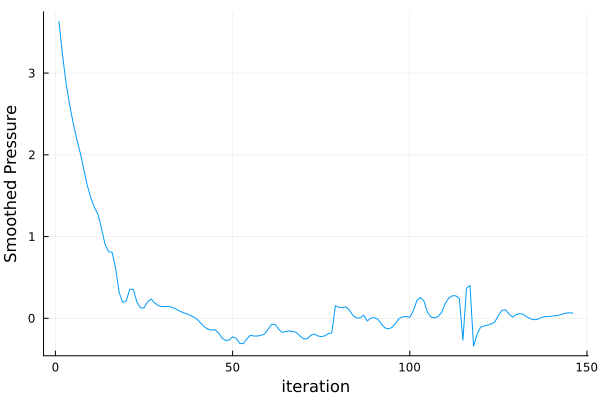

In [69]:
p = Plots.plot(P, legend=false, xlabel="iteration", ylabel="Smoothed Pressure")
p4b=p
#plot_save(p)
display(p)

In [70]:
println(P)

Any[3.630925135952225, 3.2255162473870365, 2.8766209099721873, 2.6172582592215443, 2.392903686146631, 2.19690777115994, 2.024048262309949, 1.825197305735947, 1.6247769738534987, 1.4719894198198415, 1.357576822898251, 1.2740774621023272, 1.1016110732357873, 0.9061218167794552, 0.8157575636330894, 0.807646730899861, 0.6078462547260449, 0.31424064326812523, 0.1942992706845942, 0.21442793209434216, 0.35658171434609454, 0.3530834539752029, 0.199680102957867, 0.12803262572717192, 0.12695556636402927, 0.20043679841897338, 0.2349536315565573, 0.18729705493576787, 0.15751986443690835, 0.14294369217047315, 0.1435430390353089, 0.1448821394380046, 0.13212089986540393, 0.11395827713983112, 0.08929898251404061, 0.06931463229967796, 0.05621792169950788, 0.03827717670370305, 0.015314140147493301, -0.01299237169286147, -0.057921068307786816, -0.10373244433735837, -0.13258506954211768, -0.1446708274188261, -0.13930473916168212, -0.17576181247120964, -0.24014418653010905, -0.27014888380674656, -0.2672388

In [71]:
P[86]

0.004672211092055142

In [72]:
findall(P .== minimum(P))

1-element Vector{Int64}:
 118

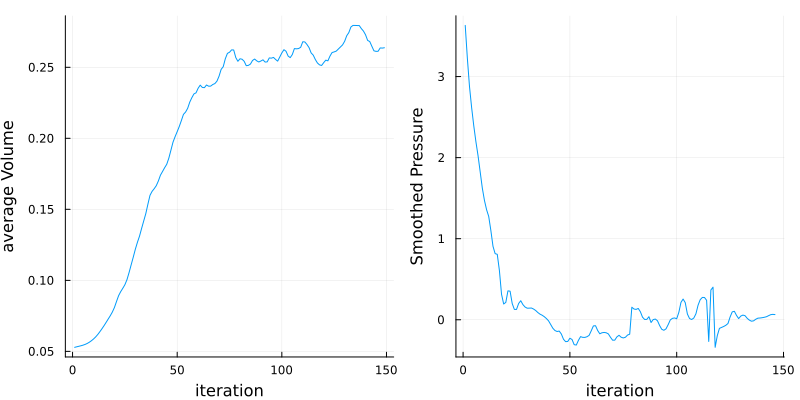

In [73]:
p = Plots.plot(p3b,p4b, layout=grid(1,2), size=(800,400) , margin=2mm )

plot_save(p)
display(p)

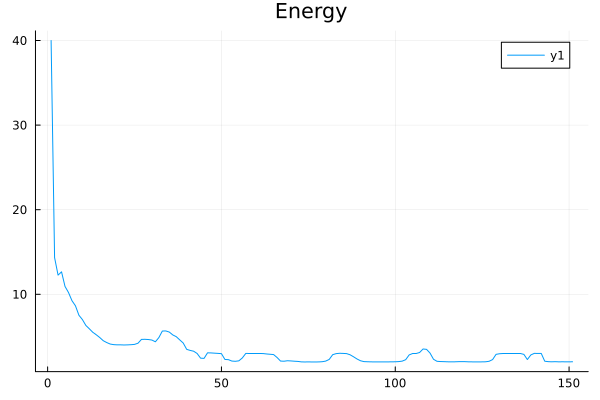

In [74]:
Plots.plot( model_df[ :, :Model_Ensemble_Energy], title="Energy" )

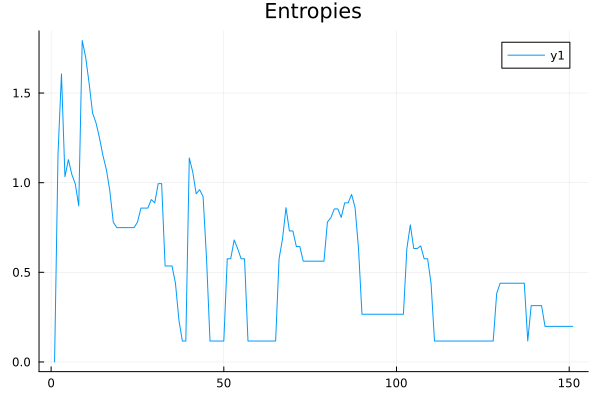

In [75]:
S_vals = model_df[ :, :Model_Thermo_State] .|> x -> x["S"]
Plots.plot( S_vals, title="Entropies" )

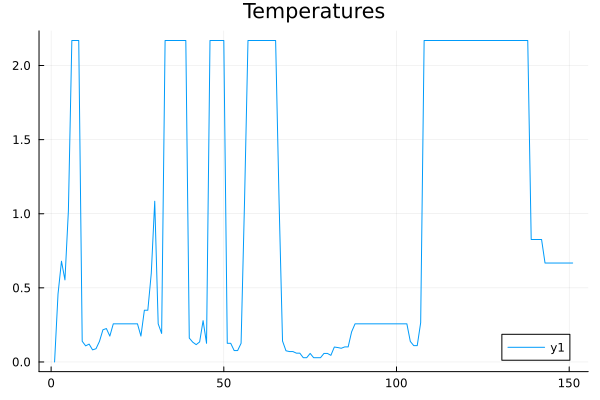

In [76]:
T_vals = model_df[ :, :Model_Thermo_State] .|> x -> x["T"]
Plots.plot( T_vals, title="Temperatures" )

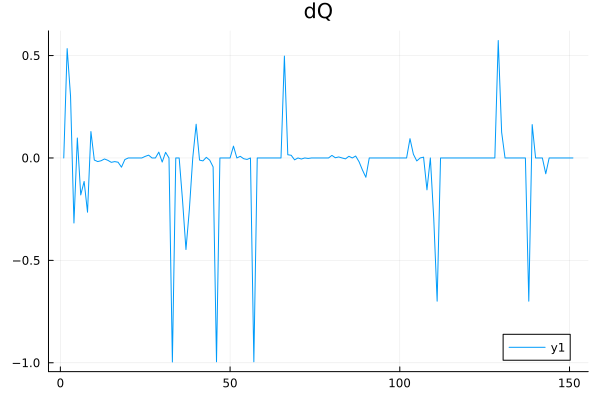

In [77]:
dQ_vals = model_df[ :, :Model_Thermo_State] .|> x -> x["dQ"]
Plots.plot( dQ_vals, title="dQ" )

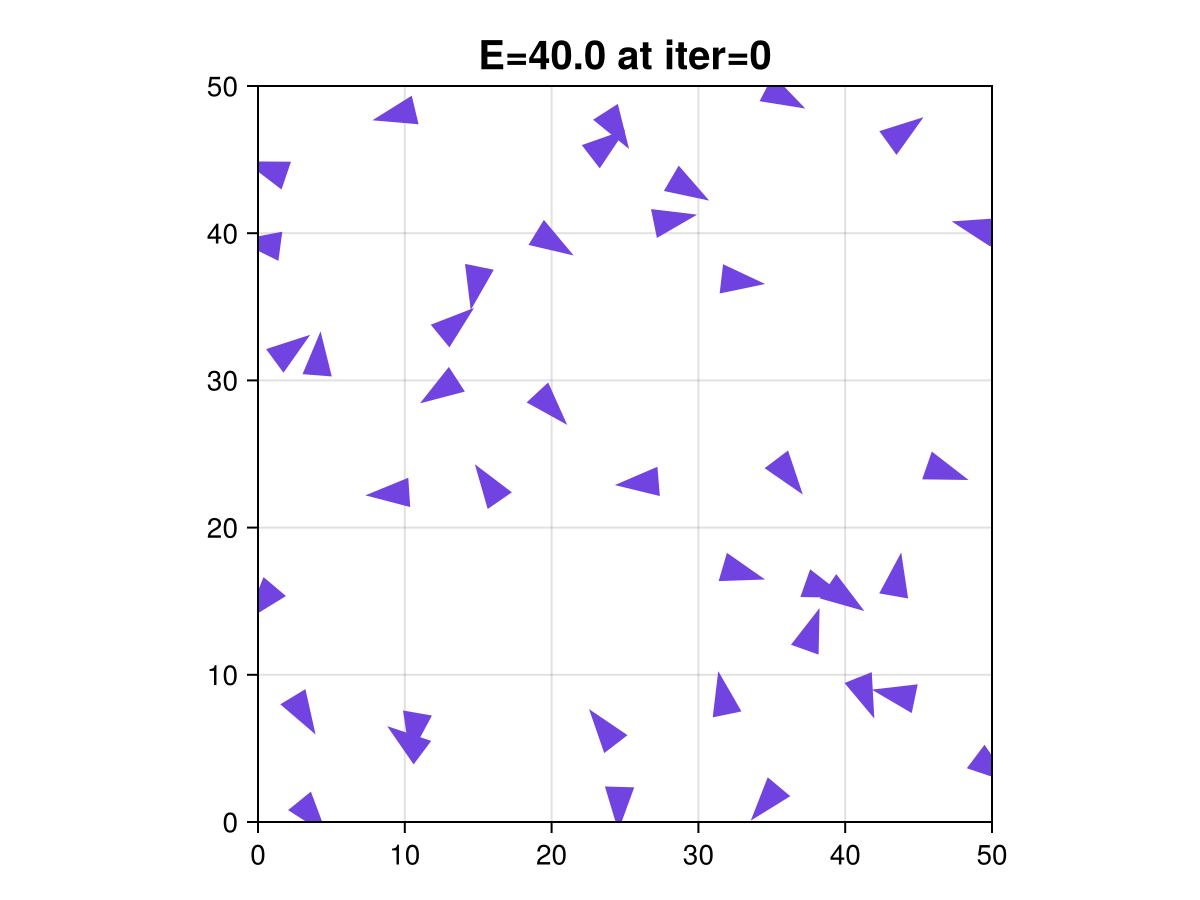

CairoMakie.Screen{IMAGE}


In [78]:
p = model_df[ 1, :Flock_Model_State]
save("stateIter0.pdf", p)
display(p)

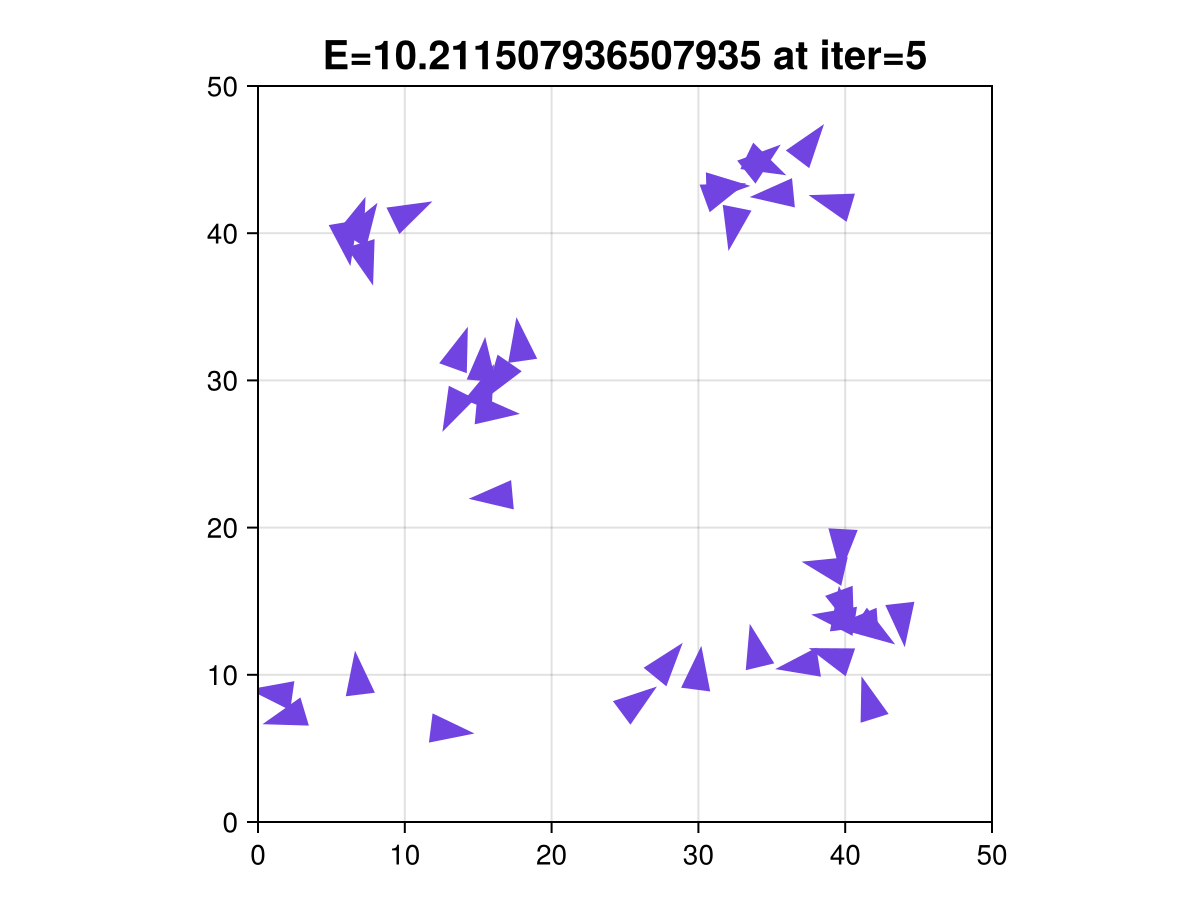

CairoMakie.Screen{IMAGE}


In [79]:
p = model_df[ 5+1, :Flock_Model_State]
save("stateIter5.pdf", p)
display(p)

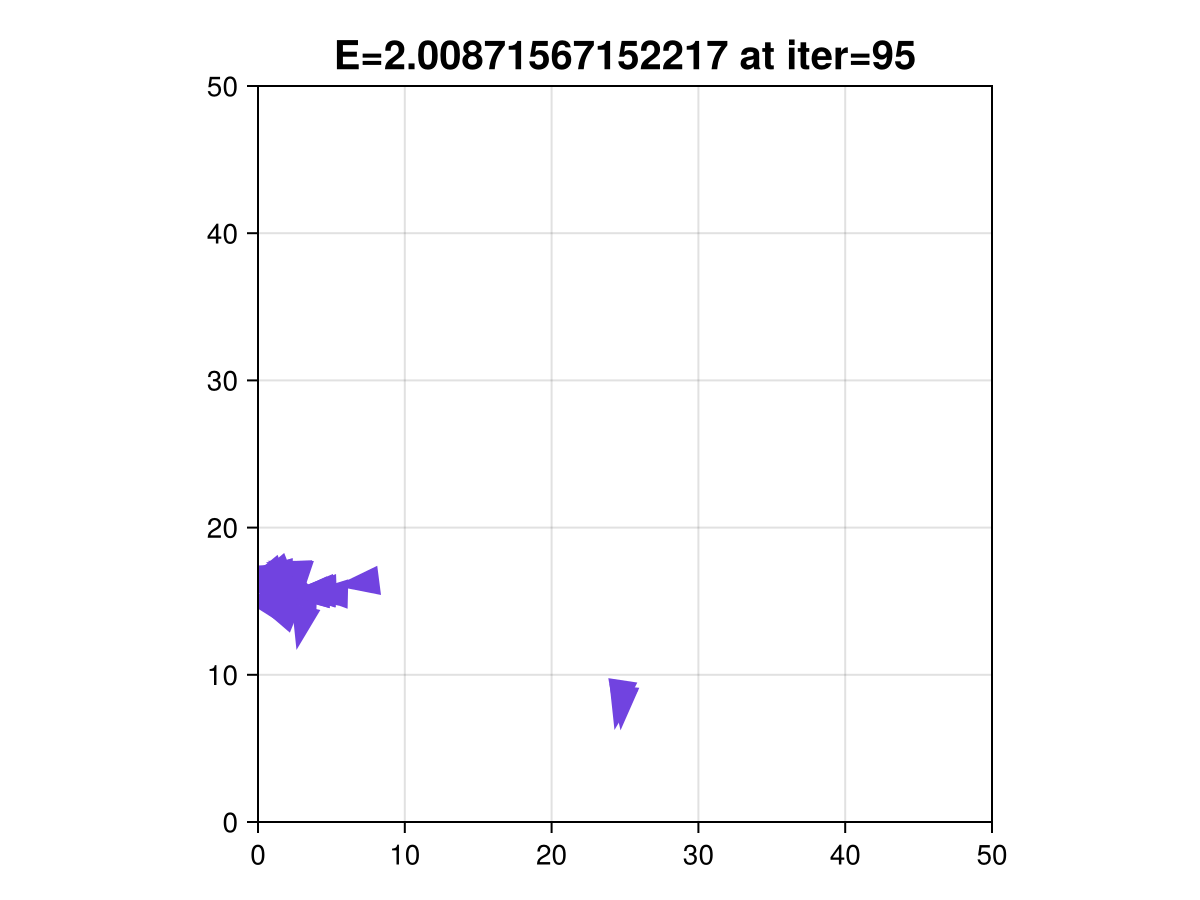

CairoMakie.Screen{IMAGE}


In [80]:
p = model_df[ 95+1, :Flock_Model_State]
save("stateIter95.pdf", p)
display(p)

In [1]:
#New Direction for Research

In [2]:
using Pkg
Pkg.add("GaussianMixtures")

    Updating registry at `C:\Users\victo\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\victo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\victo\.julia\environments\v1.10\Manifest.toml`
Precompiling project...
  ? StochasticDiffEq
  ? DifferentialEquations


In [3]:
using GaussianMixtures

In [7]:
using Agents
using CairoMakie
using Makie
using GeometryBasics
using Random
using LinearAlgebra
using Plots
using KernelDensity
using QuadGK
using Interpolations
using StatsBase
using Statistics
using DataFrames
using Loess
using DataStructures
using Measures
using InteractiveDynamics
using StaticArrays
using GaussianMixtures  # Added GaussianMixtures

In [8]:
function agent_step!(bird, model)
    # Obtain the IDs of neighbors within the bird's visual distance
    neighbor_ids = nearby_ids(bird, model, bird.visual_distance)

    match = separate = cohere = (0.0, 0.0)
    
    angle_threshold = 120 * (pi / 180)
    bird_speed = norm(bird.vel)
    ensemble_count = 0
        
    for id in neighbor_ids
        neighbor = model[id].pos
        heading = neighbor .- bird.pos

        # Compute the average position of neighboring birds
        cohere = cohere .+ heading

        if euclidean_distance(bird.pos, neighbor, model) < bird.separation
            # Repel the bird away from neighboring birds
            separate = separate .- heading
        end

        # Compute the average trajectory of neighboring birds
        match = match .+ model[id].vel
        
        neighbor_speed = norm(model[id].speed)        
        angle_between = acos(dot(bird.vel, model[id].vel) / (bird_speed * neighbor_speed + 1e-9))  # Avoid division by zero
        speed_difference = abs(bird_speed - neighbor_speed) / (bird_speed + 1e-9)  # Avoid division by zero
        
        if angle_between < angle_threshold
            ensemble_count += 1
        end        
    end
    
    N = max(length(collect(neighbor_ids)), 1)
    
    # Update the ensemble history
    push!(bird.ensemble_history, length(collect(neighbor_ids)))
    
    bird.ensemble = 1 / (1 + median(bird.ensemble_history))
    
    # Normalize results based on model input and neighbor count
    cohere = cohere ./ N .* bird.cohere_factor
    separate = separate ./ N .* bird.separate_factor
    match = match ./ N .* bird.match_factor

    # Compute velocity based on rules defined above
    bird.vel = (bird.vel .+ cohere .+ separate .+ match) ./ 2
    bird.vel = bird.vel ./ norm(bird.vel)

    # Move bird according to new velocity and speed
    move_agent!(bird, model, bird.speed)
end


agent_step! (generic function with 1 method)

In [10]:
# Function to fit a Gaussian Mixture Model (GMM) to bird positions
function fit_gmm_to_birds(model, num_components)
    positions = [bird.pos for bird in allagents(model)]
    data = hcat(positions...)
    gmm = GMM(num_components, data)
    return gmm
end

# Function to cluster birds based on GMM
function cluster_birds(gmm, model)
    positions = [bird.pos for bird in allagents(model)]
    data = hcat(positions...)
    labels = assign(gmm, data)
    return labels
end

# Function to calculate entropy of the GMM
function calculate_entropy(gmm, data)
    probs = pdf(gmm, data)
    entropy = -sum(probs .* log.(probs))
    return entropy
end

# Function to plot density based on GMM
function plot_density(gmm, model)
    positions = [bird.pos for bird in allagents(model)]
    data = hcat(positions...)
    density = pdf(gmm, data)
    scatter(data[1, :], data[2, :], marker_z = density)
end


plot_density (generic function with 1 method)

In [11]:
# Model step function to update the state of the system
function model_step!(model)
    gmm = fit_gmm_to_birds(model, 3)  # Fit a GMM with 3 components
    labels = cluster_birds(gmm, model)
    positions = [bird.pos for bird in allagents(model)]
    data = hcat(positions...)
    entropy = calculate_entropy(gmm, data)
    
    println("Entropy: ", entropy)
    plot_density(gmm, model)
end

# Initialize model and execute GMM clustering, entropy calculation, and visualization
model = initialize_model(agent_step! = agent_step!, model_step! = model_step!)
gmm = fit_gmm_to_birds(model, 3)  # Fit a GMM with 3 components
println(gmm)


UndefVarError: UndefVarError: `initialize_model` not defined

In [13]:
# Clustering
labels = cluster_birds(gmm, model)
println("Cluster labels: ", labels)

# Entropy Calculation
positions = [bird.pos for bird in allagents(model)]
data = hcat(positions...)
entropy = calculate_entropy(gmm, data)
println("Entropy: ", entropy)

# Density Plot
plot_density(gmm, model)

UndefVarError: UndefVarError: `gmm` not defined

In [22]:
function fit_gmm_to_birds(model, num_components)
    positions = [bird.pos for bird in allagents(model)]
    data = hcat(positions...)
    gmm = GMM(num_components, data)
    return gmm
end

# Initialize the model and fit a Gaussian Mixture Model (GMM)
model = initialize_model(agent_step! = agent_step!, model_step! = model_step!)
gmm = fit_gmm_to_birds(model, 3)  # Fit a GMM with 3 components
println(gmm)


MethodError: MethodError: no method matching initialize_model(; agent_step!::typeof(agent_step!), model_step!::typeof(model_step!))

Closest candidates are:
  initialize_model(; num_birds, space_size) got unsupported keyword arguments "agent_step!", "model_step!"
   @ Main c:\Users\victo\OneDrive\Documents\2025 Research for PHD Project\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y221sZmlsZQ==.jl:2


In [14]:
# Define the Bird agent structure
mutable struct Bird <: AbstractAgent
    id::Int
    pos::SVector{2, Float64}
    vel::SVector{2, Float64}
    speed::Float64
    visual_distance::Float64
    separation::Float64
    cohere_factor::Float64
    separate_factor::Float64
    match_factor::Float64
    ensemble::Float64
    ensemble_history::Vector{Float64}
end



In [21]:
# Initialize the model with a given number of birds
function initialize_model(; num_birds=100, space_size=(100.0, 100.0))
    space = ContinuousSpace(space_size...)
    properties = Dict(:step => 0)
    model = ABM(Bird, space; properties=properties)

    for i in 1:num_birds
        pos = SVector(rand() * space_size[1], rand() * space_size[2])
        vel = normalize(SVector(rand() - 0.5, rand() - 0.5))
        speed = 1.0 + rand() * 2.0
        visual_distance = 10.0
        separation = 2.0
        cohere_factor = 0.01
        separate_factor = 0.05
        match_factor = 0.125
        ensemble = 0.0
        ensemble_history = Float64[]
        bird = Bird(i, pos, vel, speed, visual_distance, separation, cohere_factor, separate_factor, match_factor, ensemble, ensemble_history)
        add_agent!(bird, model)
    end

    return model
end


initialize_model (generic function with 1 method)

In [16]:
# Fit a Gaussian Mixture Model (GMM) to bird positions
function fit_gmm_to_birds(model, num_components)
    positions = [bird.pos for bird in allagents(model)]
    data = hcat(positions...)
    gmm = GMM(num_components, data)
    return gmm
end

# Cluster birds based on GMM
function cluster_birds(gmm, model)
    positions = [bird.pos for bird in allagents(model)]
    data = hcat(positions...)
    labels = assign(gmm, data)
    return labels
end

cluster_birds (generic function with 1 method)

In [17]:
# Calculate entropy from the GMM probability distribution
function calculate_entropy(gmm, data)
    probs = pdf(gmm, data)
    entropy = -sum(probs .* log.(probs))
    return entropy
end

# Plot density distribution of birds based on GMM
function plot_density(gmm, model)
    positions = [bird.pos for bird in allagents(model)]
    data = hcat(positions...)
    density = pdf(gmm, data)
    scatter(data[1, :], data[2, :], marker_z=density)
end


plot_density (generic function with 1 method)

In [18]:
# Model step function: updates the state of the system at each step
function model_step!(model)
    gmm = fit_gmm_to_birds(model, 3)  # Fit a GMM with 3 components
    labels = cluster_birds(gmm, model)
    positions = [bird.pos for bird in allagents(model)]
    data = hcat(positions...)
    entropy = calculate_entropy(gmm, data)

    println("Entropy: ", entropy)
    plot_density(gmm, model)
end

model_step! (generic function with 1 method)

In [19]:
# Initialize model and execute GMM clustering, entropy calculation, and visualization
model = initialize_model(agent_step! = agent_step!, model_step! = model_step!)
gmm = fit_gmm_to_birds(model, 3)  # Fit a GMM with 3 components
println(gmm)


MethodError: MethodError: no method matching initialize_model(; agent_step!::typeof(agent_step!), model_step!::typeof(model_step!))

Closest candidates are:
  initialize_model(; num_birds, space_size) got unsupported keyword arguments "agent_step!", "model_step!"
   @ Main c:\Users\victo\OneDrive\Documents\2025 Research for PHD Project\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y221sZmlsZQ==.jl:2


In [20]:
# Clustering
labels = cluster_birds(gmm, model)
println("Cluster labels: ", labels)

# Entropy Calculation
positions = [bird.pos for bird in allagents(model)]
data = hcat(positions...)
entropy = calculate_entropy(gmm, data)
println("Entropy: ", entropy)

# Density Plot
plot_density(gmm, model)

UndefVarError: UndefVarError: `gmm` not defined